In [1]:
import torch

import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision import transforms as tf, datasets as ds
from torchvision.utils import make_grid

from utils.models import ColorNet, lab2rgb, color, train

In [2]:
data_root_color = 'C:/DataSets/Celeba/sample'
data_root_grayscale = 'C:/DataSets/Celeba/grayscale'
workers = 0
batch_size = 64
image_size = 64
nc = 3  # Number of output color channels.
nz = 1  # Number of input color channels (Latent vector).
ngf = 64    # Depth of feature map, carried through the generator(G).
ndf = 64    # Depth of feature map, carried through the discriminator(D).
number_epochs = 5
lr = 2e-4
beta = 5e-1
ngpu = 1
weight_decay = 1e-1

In [3]:
is_cuda_available = torch.cuda.is_available()
device = torch.device('cuda:0' if is_cuda_available and ngpu > 0 else 'cpu')
device

device(type='cuda', index=0)

In [4]:
image_transform = {
    "rgb": tf.Compose([
        tf.Resize(image_size),
        tf.CenterCrop(image_size),
        tf.ToTensor()
        # tf.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]),
    "gray": tf.Compose([
        tf.Resize(image_size),
        tf.CenterCrop(image_size),
        tf.ToTensor()
        # tf.Normalize(mean=[0.5], std=[0.5])
    ])
}

In [5]:
# Grayscale image dataset load.
gray_set = ds.ImageFolder(root=data_root_grayscale, transform=image_transform["gray"])

In [6]:
gray_loader = DataLoader(gray_set, batch_size, shuffle=True, num_workers=workers, pin_memory=is_cuda_available)

Text(0.5, 1.0, 'GRAYSCALE IMAGE SAMPLE')

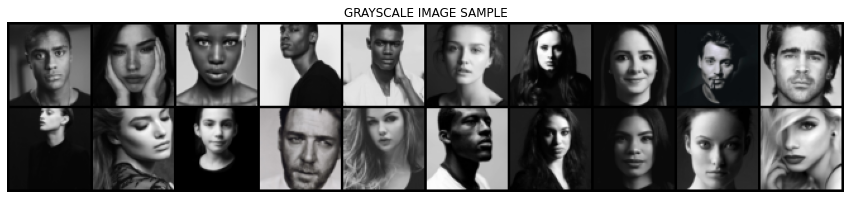

In [7]:
g_im = next(iter(gray_loader))

g_grid = make_grid(g_im[0], nrow=10, normalize=True)

plt.figure(figsize=(15, 14))
plt.imshow(np.transpose(g_grid, axes=(1, 2, 0)))
plt.axis('off')
plt.title('GRAYSCALE IMAGE SAMPLE')

In [8]:
color_set = ds.ImageFolder(root=data_root_color, transform=image_transform["rgb"])

In [9]:
color_loader = DataLoader(color_set, batch_size, shuffle=False, num_workers=workers, pin_memory=is_cuda_available)

Text(0.5, 1.0, 'COLOR IMAGE SAMPLE')

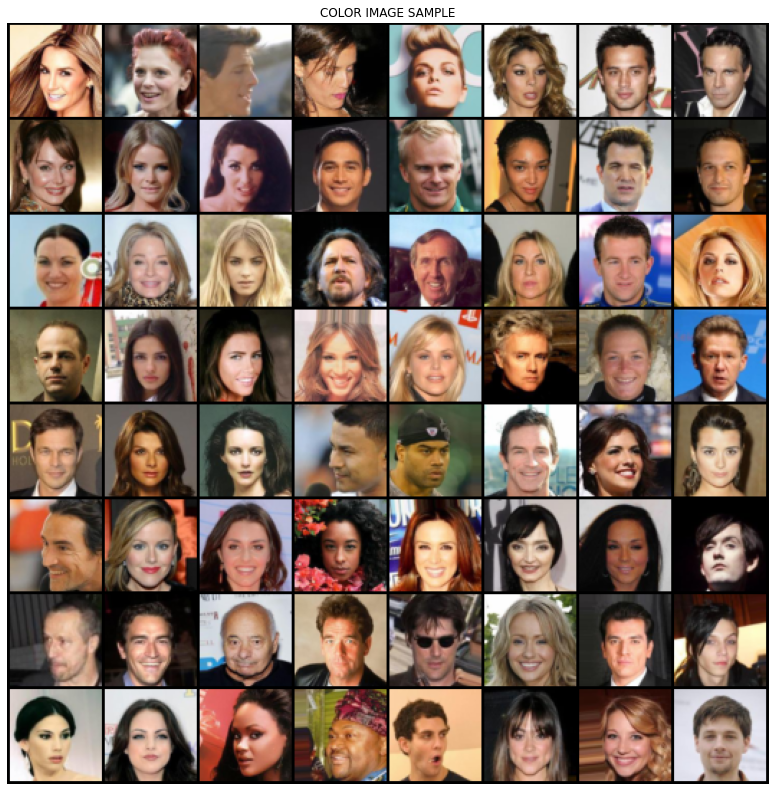

In [10]:
c_im = next(iter(color_loader))

c_grid = make_grid(c_im[0], nrow=8, normalize=True)

plt.figure(figsize=(15, 14))
plt.imshow(np.transpose(c_grid, axes=(1, 2, 0)))
plt.axis('off')
plt.title('COLOR IMAGE SAMPLE')

In [11]:
class RGB2LAB(object):

    def __call__(self, image):
        """
        :param image: PIL/NumPy image to be converted.
        :return: the LAB color channel image.
        """
        return color.rgb2lab(np.array(image))

class RGB2L(object):

    def __call__(self, image):
        """
        :param image: PIL/NumPy image to be converted.
        :return: the LAB color channel image.
        """
        return color.rgb2lab(np.array(image))[:, :, 0]


In [12]:
image_transform['lab'] = tf.Compose([
    tf.Resize(image_size),
    tf.CenterCrop(image_size),
    RGB2LAB(),
    tf.ToTensor()
    # tf.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

image_transform['l'] = tf.Compose([
    tf.Resize(image_size),
    tf.CenterCrop(image_size),
    RGB2L(),
    tf.ToTensor()
    # tf.Normalize(mean=[0.5], std=[0.5])
])

In [13]:
lab_set = ds.ImageFolder(root=data_root_color, transform=image_transform['lab'])
lab_loader = DataLoader(lab_set, batch_size, num_workers=workers, pin_memory=is_cuda_available)

In [14]:
l_set = ds.ImageFolder(root=data_root_color, transform=image_transform['l'])
l_loader = DataLoader(l_set, batch_size, num_workers=workers, pin_memory=is_cuda_available)

Text(0.5, 1.0, 'B CHANNEL SAMPLE')

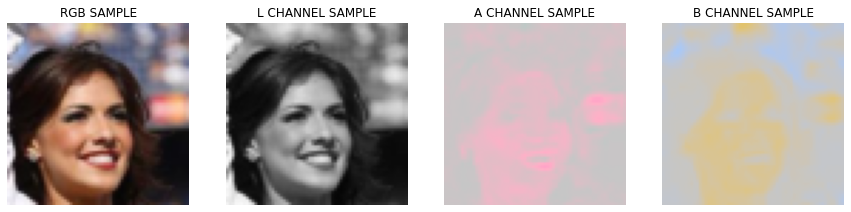

In [15]:
IMG_INDEX = 38

lab_im = next(iter(lab_loader))[0][IMG_INDEX]

plt.figure(figsize=(15, 14))

plt.subplot(141)
plt.imshow(np.transpose(c_im[0][IMG_INDEX], axes=(1, 2, 0)))
plt.axis('off')
plt.title('RGB SAMPLE')

plt.subplot(142)
plt.imshow(lab2rgb(lab_im, 0))
plt.axis('off')
plt.title('L CHANNEL SAMPLE')

plt.subplot(143)
plt.imshow(lab2rgb(lab_im, 1))
plt.axis('off')
plt.title('A CHANNEL SAMPLE')

plt.subplot(144)
plt.imshow(lab2rgb(lab_im, 2))
plt.axis('off')
plt.title('B CHANNEL SAMPLE')

In [22]:
l_im = next(iter(l_loader))

## Colorizing Images with Supervised Learning

In [17]:
colorNet = ColorNet().to(device).double()
colorNet

ColorNet(
  (main): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Upsample(scale_factor=2.0, mode=nearest)
    (4): Conv2d(32, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Upsample(scale_factor=2.0, mode=nearest)
    (8): Conv2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Upsample(scale_factor=2.0, mode=nearest)
    (12): Conv2d(64, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Upsample(scale_factor=2.0, mode=nearest)
    (16): Conv2d(8, 3, kernel_size=(3, 3),

In [18]:
losses = train(colorNet, 10, l_loader, lab_loader, device)

Epoch: 1/10, Batch: 1/400 => Loss: 1155.2345583618758
Epoch: 1/10, Batch: 100/400 => Loss: 892.6399047491094
Epoch: 1/10, Batch: 200/400 => Loss: 608.2018193528172
Epoch: 1/10, Batch: 300/400 => Loss: 414.22763091117935
Epoch: 1/10, Batch: 400/400 => Loss: 225.74826556328594
Epoch: 2/10, Batch: 1/400 => Loss: 231.09884498695638
Epoch: 2/10, Batch: 100/400 => Loss: 135.9688979799226
Epoch: 2/10, Batch: 200/400 => Loss: 87.522644791628
Epoch: 2/10, Batch: 300/400 => Loss: 97.80084780851094
Epoch: 2/10, Batch: 400/400 => Loss: 104.69984639432681
Epoch: 3/10, Batch: 1/400 => Loss: 91.37471184923366
Epoch: 3/10, Batch: 100/400 => Loss: 71.520177232901
Epoch: 3/10, Batch: 200/400 => Loss: 64.57593174333573
Epoch: 3/10, Batch: 300/400 => Loss: 85.02636971870183
Epoch: 3/10, Batch: 400/400 => Loss: 100.62622468075304
Epoch: 4/10, Batch: 1/400 => Loss: 86.49806707138924
Epoch: 4/10, Batch: 100/400 => Loss: 69.08855510943377
Epoch: 4/10, Batch: 200/400 => Loss: 63.07318246654071
Epoch: 4/10, Bat

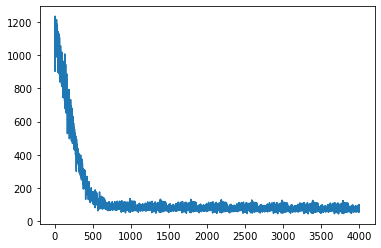

In [19]:
plt.plot(losses)

In [40]:
@torch.no_grad()
def view(image):

    colorNet.eval()

    image = colorNet(image.to(device))
    print(image.shape)

    image = lab2rgb(image.cpu().numpy().reshape(-1, 64, 64))

    return image

torch.Size([1, 3, 64, 64])


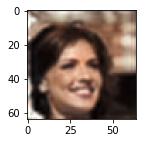

In [68]:
image = l_im[0][38]
image = view(image.view(-1, 1, 64, 64).double())

plt.figure(figsize=(3, 2))
plt.imshow(image)